<a href="https://colab.research.google.com/github/sujitojha1/EVA4/blob/rev4/S11/EVA4_S11_Solution_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 4, Session11 : CIFAR 10

**Target**: 


*  Write a code that draws this curve (without the arrows). In submission, you'll upload your drawn curve and code for that
    * 11s11.png 
*  Write a code which
  1. uses this new ResNet Architecture for Cifar10:
    * PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
    * Layer1 -
        * X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        * R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
        * Add(X, R1)
    * Layer 2 -
        * Conv 3x3 [256k]
        * MaxPooling2D
        * BN
        * ReLU
    * Layer 3 -
        * X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
        * R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        * Add(X, R2)
    * MaxPooling with Kernel Size 4
    * FC Layer 
    * SoftMax
  2. Uses One Cycle Policy such that:
    * Total Epochs = 24
    * Max at Epoch = 5
    * LRMIN = FIND
    * LRMAX = FIND
    * NO Annihilation
  3. Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
  4. Batch size = 512
  5. Target Accuracy: 90%. 
  6. The lesser the modular your code is (i.e. more the code you have written in your Colab file), less marks you'd get. 
* Questions asked are:
  1. Upload the code you used to draw your ZIGZAG or CYCLIC TRIANGLE plot.
  2. Upload your triangle Plot which was drawn with your code.
  3. Upload the link to your GitHub copy of Colab Code. 
  4. Upload the github link for the model as described in A11. 
  5. What is your test accuracy?

**Results**

*  Total Parameters = 6,573,120
*  After 24 Epochs, Final Train Accuracy = 95.75%
*  After 24 Epochs, Final Test Accuracy = 90.27%

**Analysis**

*  Target accuracy > 90% using Reset18 new architecture. Model performance is slightly overfitting.

## 1. Loading Module and Models 

In [2]:
# Load modules/models from EVA course
!rm -rf EVA4
!git clone -b rev4 https://github.com/sujitojha1/EVA4 -q --quiet
print("Loaded EVA4 Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
#pip install apex -q

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA4 Modules and Models



## 2. Loading train and test data with transforms and loader functions

In [3]:
from EVA4.Modules import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [4]:
cifar10.data_summary_stats()
#print(vars(train))

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


### 3.2 Plotting sample images

Files already downloaded and verified


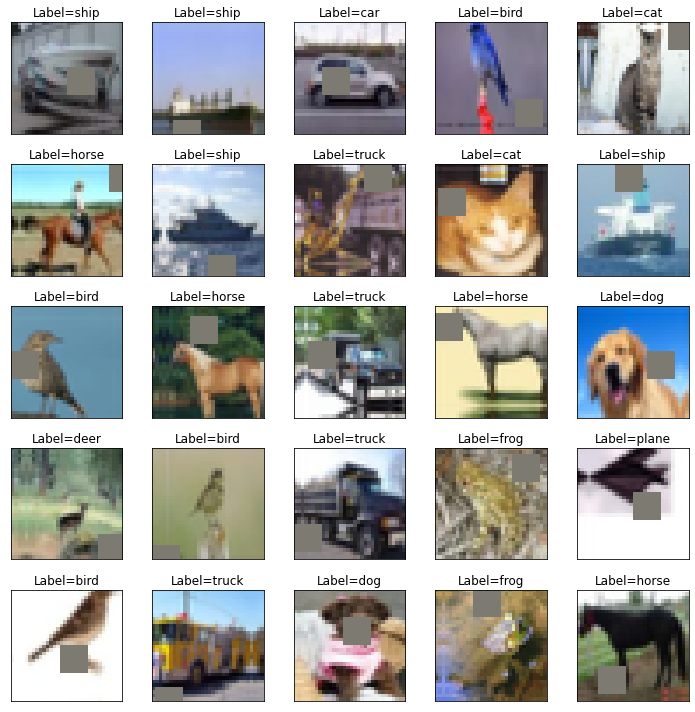

In [5]:
cifar10.sample_pictures(train_flag=True)

# The Model

In [6]:
from EVA4.Models import *

# Loading ResNet18 Model
net = ResNet_Cifar10()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [7]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

# Define a Loss function and optimizer

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


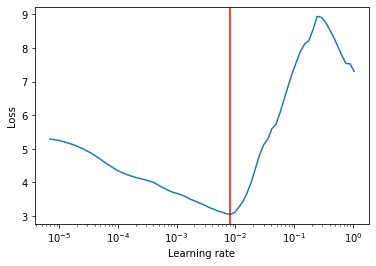

In [8]:
from EVA4.Modules import LRFinder
import torch.optim as optim

model = net
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.008) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [0]:
#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.10, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.02, 
                                          steps_per_epoch=98, 
                                          pct_start=0.20, 
                                          epochs=25,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

# Training and Testing

In [10]:
# Load train and test model
from EVA4.Modules import *

train = train()
test = test()

for epoch in range(25):  # loop over the dataset multiple times

    train.execute(net, device, trainloader, optimizer, criterion, epoch,scheduler)
    test.execute(net, device, testloader, criterion)

print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 0


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5004/10000 (50.04%)


Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5967/10000 (59.67%)


Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6513/10000 (65.13%)


Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6875/10000 (68.75%)


Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 7078/10000 (70.78%)


Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7675/10000 (76.75%)


Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7794/10000 (77.94%)


Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8033/10000 (80.33%)


Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8308/10000 (83.08%)


Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8176/10000 (81.76%)


Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8282/10000 (82.82%)


Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8154/10000 (81.54%)


Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8558/10000 (85.58%)


Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8706/10000 (87.06%)


Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8597/10000 (85.97%)


Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8544/10000 (85.44%)


Epoch: 16


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8766/10000 (87.66%)


Epoch: 17


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8761/10000 (87.61%)


Epoch: 18


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8759/10000 (87.59%)


Epoch: 19


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8816/10000 (88.16%)


Epoch: 20


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8879/10000 (88.79%)


Epoch: 21


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8922/10000 (89.22%)


Epoch: 22


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8978/10000 (89.78%)


Epoch: 23


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9008/10000 (90.08%)


Epoch: 24


Loss=0.1347 Batch_id=97 LR=-0.0000 Accuracy=95.75: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]



Test set: Average loss: 0.0006, Accuracy: 9027/10000 (90.27%)

Finished Training


# Misclassified images


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


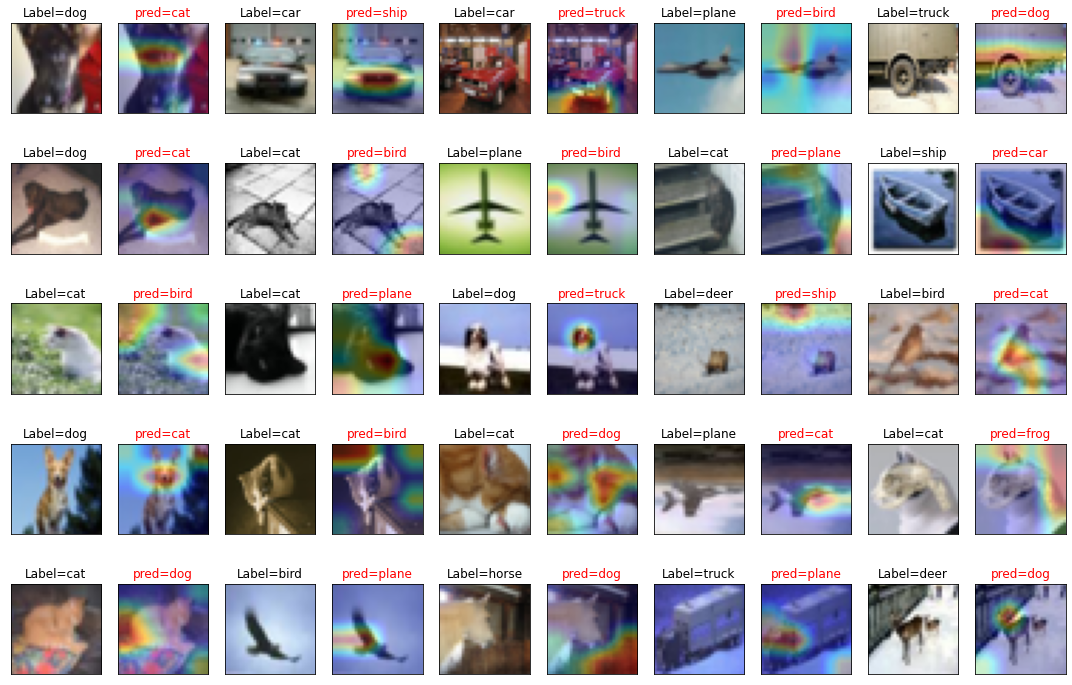

In [12]:
plot_misclassified_images_w_gradcam(net,device,testloader,classes)

# Plotting Train & Test Accuracy/Losses

# Evaluating test Accuracy over different classes 

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 66 %
Accuracy of   cat : 70 %
Accuracy of  deer : 85 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 92 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


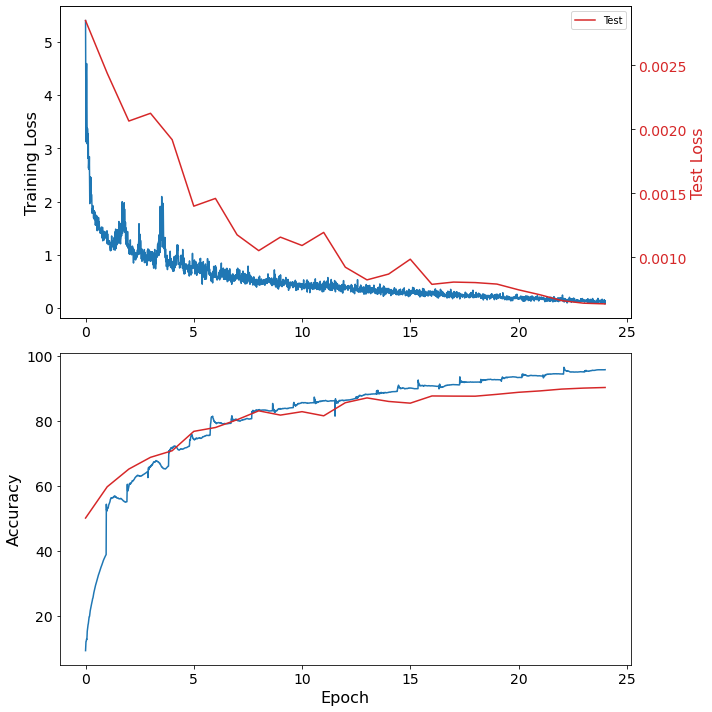

In [14]:
plot_train_test_acc_loss(train,test)